In [4]:
import os
if not os.path.exists('common.py'):
    print('trying to find project root directory by chaning to parent directory')
    os.chdir('..')
if os.path.exists('common.py'):
    print('all good')
else:
    print('could not find project root directory')

all good


In [5]:
import numpy as np
import pandas as pd

from common import OUTPUTPATH
import data
from models import linear_pcc, gam_pcc, rule_fit_pcc, random_forest_pcc
from modules.experiments import Experiment, KFold, hamming_loss, error, NegLogLikelihoodEvaluator, ExtrapolationExperiment, GroupKFoldSpecial, GroupDescription

indx = data.y[(data.y.sphere == 0) & (data.y.worm == 0) & (data.y.vesicle == 0)& (data.y.other == 0)].index 

polymers = data.polymers.iloc[~data.polymers.index.isin(indx)]
x1 = pd.get_dummies(polymers.filter(data.predictors, axis=1))
y = polymers.filter(data.targets, axis=1)
comp_ids = polymers.loc[:, data.corona_comp+data.core_comp].apply(data.get_comp_id, axis = 1)

In [ ]:
STATE = np.random.RandomState(seed=1000)
full_estimators = [linear_pcc, gam_pcc, rule_fit_pcc, random_forest_pcc]
full_names = ['LR', 'GAM', 'RuFit', 'RF']

no_assemble_interpolation = Experiment(full_estimators, 
                            full_names,
                            KFold(30, shuffle=True, random_state=STATE),
                            x1, y.replace(-1.0, 0.0),
                            groups=comp_ids.array,
                            evaluators=[hamming_loss, error, NegLogLikelihoodEvaluator(base=2)],
                            verbose=True).run()

no_assemble_extrapolation = ExtrapolationExperiment(full_estimators, 
                            full_names,
                            GroupKFoldSpecial(len(set(data.comp_ids)), size=22),
                            x1, y.replace(-1.0, 0.0), groups=comp_ids.array,
                            evaluators=[hamming_loss, error, NegLogLikelihoodEvaluator(base=2),
                            GroupDescription(data.comp_descr, 'composition')],
                            verbose=True).run()

In [11]:
interpolation = pd.read_csv(os.path.join(OUTPUTPATH, 'interpolation.csv'))
interpolation = interpolation.set_index('Unnamed: 0')
interpolation.index.name = None

extrapolation = pd.read_csv(os.path.join(OUTPUTPATH, 'extrapolation.csv'))
extrapolation = extrapolation.set_index('Unnamed: 0')
extrapolation.index.name = None

In [12]:
sel_column = ['mean_test_hamming loss', 'std_test_hamming loss', 'mean_test_error', 'std_test_error', 'mean_test_log loss',	'std_test_log loss']
no_assemble_interpolation.index = interpolation.index
interpolation_diff = no_assemble_interpolation - interpolation
interpolation_diff[sel_column]

,mean_test_hamming loss,std_test_hamming loss,mean_test_error,std_test_error,mean_test_log loss,std_test_log loss
LR,-0.013640,-0.005790,-0.074825,-0.014465,-0.199702,-0.025842
GAM,-0.003377,0.009284,-0.005789,0.016266,0.014951,0.125871
RuleFit,-0.003662,0.003787,-0.025263,0.003353,-0.057885,0.231050
RF,-0.005022,0.008758,-0.006667,0.030989,-0.030449,0.023656


In [13]:
no_assemble_extrapolation.index = extrapolation.index
extrapolation_diff = no_assemble_extrapolation - extrapolation
extrapolation_diff[sel_column]

,mean_test_hamming loss,std_test_hamming loss,mean_test_error,std_test_error,mean_test_log loss,std_test_log loss
Lr_pcc,-0.025012,0.011158,-0.124855,0.016369,-0.090923,-0.040421
GAM_pcc,-0.012370,0.000786,-0.048873,-0.023652,0.123604,0.278087
RuFit_pcc,0.021269,0.017601,0.015541,-0.005431,-0.035290,0.289376
RF_pcc,-0.006280,0.000606,-0.027559,-0.020124,-0.135824,-0.130741


In [14]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)

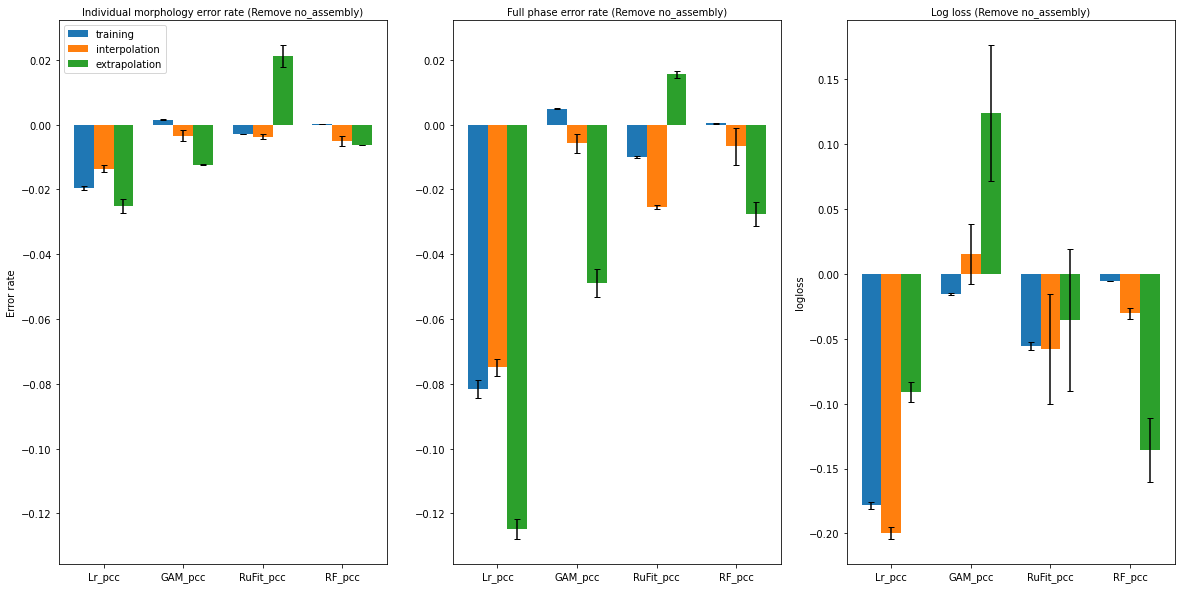

In [15]:
colors = ['r', 'c', 'm', 'y', 'b']
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=False, sharex=True, figsize=(20, 10))

width = 0.25
fontsize = 10
ind = np.arange(len(interpolation))

ax1.bar(ind-width, interpolation_diff[f'mean_train_hamming loss'], width=width, label='training', 
        yerr=interpolation_diff[f'std_train_hamming loss']/30**0.5, capsize=3.0)
ax1.bar(ind, interpolation_diff[f'mean_test_hamming loss'], width=width, label='interpolation',
        yerr=interpolation_diff[f'std_test_hamming loss']/30**0.5, capsize=3.0)
ax1.bar(ind+width, extrapolation_diff[f'mean_test_hamming loss'], width=width, label='extrapolation',
        yerr=extrapolation_diff[f'std_test_hamming loss']/28**0.5, capsize=3.0)

ax1.set_title('Individual morphology error rate (Remove no_assembly)', fontsize=fontsize)
ax1.set_xticks(ind)
ax1.set_ylabel('Error rate', fontsize=fontsize)
ax1.set_xticklabels(interpolation.index, fontsize=fontsize)

ax1.legend(fontsize=fontsize)
ax1.sharey(ax2) ########### here to share the y axis

ax2.bar(ind-width, interpolation_diff[f'mean_train_error'], width=width, label='training', 
        yerr=interpolation_diff[f'std_train_error']/30**0.5, capsize=3.0)
ax2.bar(ind, interpolation_diff[f'mean_test_error'], width=width, label='interpolation',
        yerr=interpolation_diff[f'std_test_error']/30**0.5, capsize=3.0)
ax2.bar(ind+width, extrapolation_diff[f'mean_test_error'], width=width, label='extrapolation',
        yerr=extrapolation_diff[f'std_test_error']/28**0.5, capsize=3.0)

ax2.set_title('Full phase error rate (Remove no_assembly)', fontsize=fontsize)
ax2.set_xticks(ind)
ax2.set_xticklabels(extrapolation.index, fontsize=fontsize)
ax2.sharey(ax1) ########### here to share the y axis


ax3.bar(ind-width, interpolation_diff[f'mean_train_log loss'], width=width, label='training', 
        yerr=interpolation_diff[f'std_train_log loss']/30**0.5, capsize=3.0)
ax3.bar(ind, interpolation_diff[f'mean_test_log loss'], width=width, label='interpolation',
        yerr=interpolation_diff[f'std_test_log loss']/30**0.5, capsize=3.0)
ax3.bar(ind+width, extrapolation_diff[f'mean_test_log loss'], width=width, label='extrapolation',
        yerr=extrapolation_diff[f'std_test_log loss']/28**0.5, capsize=3.0)


ax3.set_title('Log loss (Remove no_assembly)', fontsize=fontsize)
ax3.set_xticks(ind)
ax3.set_xticklabels(extrapolation_diff.index, fontsize=fontsize)
ax3.set_ylabel('logloss', fontsize=fontsize)
plt.savefig(os.path.join(OUTPUTPATH, 'Comparison_overall_performance.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()